### Imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

import _utils
from _utils import set_all_seeds

import matplotlib as mpl 

def set_plt_layout():
    mpl.style.use('seaborn-v0_8-bright')
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42
    mpl.rcParams['text.usetex'] = False
    plt.rcParams.update({
        'axes.labelsize': 20,
        'xtick.labelsize': 20,
        'ytick.labelsize': 20,
        'legend.fontsize': 18,
        'axes.titlesize': 20,
        'axes.spines.top': False,
        'axes.spines.right': False,
        'axes.spines.bottom': False,
        'axes.spines.left': False,
        'axes.grid': False,
        'xtick.bottom': False,
        'xtick.labelbottom': False,
        'ytick.left': False,
        'ytick.labelleft': False,
        'figure.figsize': (8, 8)
    })
    mpl.rcParams['image.cmap'] = 'magma'

_utils.reset_plt_layout()
set_all_seeds(0); set_plt_layout()

### Prepare data

In [10]:
df = pd.read_pickle("data/hmtDNA/rsrs.pkl", compression='gzip')
df2 = pd.read_pickle("data/hmtDNA/rcrs.pkl", compression='gzip')

print("Before filtering")
print(df.shape)
print(df2.shape)

thr = 0.9
df = df[df['Quality'] >= thr]
df2 = df2[df2['Quality'] >= thr]

print("After filtering")
print(df.shape)
print(df2.shape)


Before filtering
(63778, 15)
(63778, 15)
After filtering
(61665, 15)
(57385, 15)


In [11]:
mlb = MultiLabelBinarizer()
one_hot = pd.DataFrame(mlb.fit_transform(df['Input_Sample'].values),
                       columns=mlb.classes_,
                       index=df.index)


# Calculate the frequency of each mutation
mutation_counts = one_hot.sum(axis=0)
total_samples = one_hot.shape[0]
mutation_frequencies = mutation_counts / total_samples

frequency_threshold = 0.0005
filtered_mutations = mutation_frequencies[mutation_frequencies >= frequency_threshold].index
one_hot_filtered = one_hot[filtered_mutations]

df['n_mutations'] = df['Input_Sample'].apply(len)
df['n_kept_mutations'] = one_hot_filtered.sum(axis=1)
df['kept_ratio'] = df['n_kept_mutations'] / df['n_mutations'] 

d_d = one_hot_filtered.loc[df.index.tolist()].values
print(d_d.shape)


(61665, 6298)


In [12]:
mlb2 = MultiLabelBinarizer()
one_hot2 = pd.DataFrame(mlb2.fit_transform(df2['Input_Sample'].values),
                       columns=mlb2.classes_,
                       index=df2.index)

# Calculate the frequency of each mutation
mutation_counts2 = one_hot2.sum(axis=0)
total_samples2 = one_hot2.shape[0]
mutation_frequencies2 = mutation_counts2 / total_samples2

# Use same frequency threshold as before
filtered_mutations2 = mutation_frequencies2[mutation_frequencies2 >= frequency_threshold].index
one_hot_filtered2 = one_hot2[filtered_mutations2]

df2['n_mutations'] = df2['Input_Sample'].apply(len)
df2['n_kept_mutations'] = one_hot_filtered2.sum(axis=1)
df2['kept_ratio'] = df2['n_kept_mutations'] / df2['n_mutations']

d2_d = one_hot_filtered2.loc[df2.index.tolist()].values
print(d2_d.shape)

(57385, 5366)


In [13]:
counts1 = d_d.sum(axis=-1)
counts2 = d2_d.sum(axis=-1)

### Data histograms

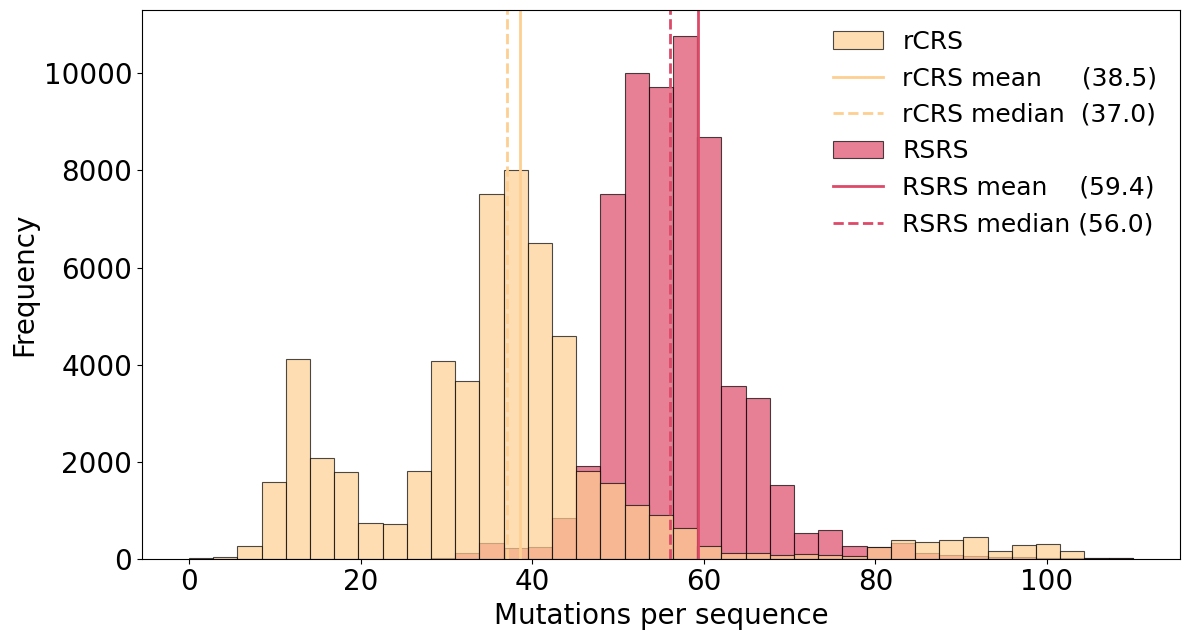

In [22]:
pos1 = counts1[counts1 > 0]
pos2 = counts2[counts2 > 0]

cmap = plt.get_cmap('magma')
color1 = cmap(0.6) 
color2 = cmap(0.9) 

bins = np.linspace(0, 110, 40)
mean1, med1 = pos1.mean(), np.median(pos1)
mean2, med2 = pos2.mean(), np.median(pos2)


label_RSRS        = 'RSRS'
label_RSRS_mean   = f'{label_RSRS} mean    ({mean1:.1f})'
label_RSRS_median = f'{label_RSRS} median ({med1:.1f})'

label_rCRS        = 'rCRS'
label_rCRS_mean   = f'{label_rCRS} mean     ({mean2:.1f})'
label_rCRS_median = f'{label_rCRS} median  ({med2:.1f})'

# plot the histograms
fig, ax = plt.subplots(figsize=(12,6.5))

ax.hist(pos1, bins=bins,
        facecolor=color1, alpha=0.7,
        edgecolor='k', linewidth=0.8,
        label=label_RSRS)

ax.hist(pos2, bins=bins,
        facecolor=color2, alpha=0.7,
        edgecolor='k', linewidth=0.8,
        label=label_rCRS)

# add the mean & median lines
ax.axvline(mean1, color=color1, linestyle='-',  linewidth=2, label=label_RSRS_mean)
ax.axvline(med1,  color=color1, linestyle='--', linewidth=2, label=label_RSRS_median)

ax.axvline(mean2, color=color2, linestyle='-',  linewidth=2, label=label_rCRS_mean)
ax.axvline(med2,  color=color2, linestyle='--', linewidth=2, label=label_rCRS_median)

# Restore axes
for spine in ['top','right','bottom','left']:
    ax.spines[spine].set_visible(True)

ax.tick_params(axis='x', which='both', bottom=True, top=False,  labelbottom=True)
ax.tick_params(axis='y', which='both', left=True,  right=False, labelleft=True)

# Build legend in the desired order
handles, labels = ax.get_legend_handles_labels()
desired_order = [
    label_rCRS,
    label_rCRS_mean,
    label_rCRS_median,
    label_RSRS,
    label_RSRS_mean,
    label_RSRS_median
]

ordered_handles = [handles[labels.index(lbl)] for lbl in desired_order]
ax.legend(
    ordered_handles,
    desired_order,
    loc='upper right',
    bbox_to_anchor=(1.0, 1.005),  # x=1.0 (right), y=1.05 (5% above)
    frameon=False
)

ax.set_xlabel('Mutations per sequence')
ax.set_ylabel('Frequency')

plt.tight_layout()
# plt.savefig(f'results/pdfs/hmtdna_distributions.pdf', dpi=300, bbox_inches='tight')
# plt.savefig(f'results/pngs/hmtdna_distributions.png', dpi=300, bbox_inches='tight')
plt.show()



/tmp/ipykernel_1407650/4181083905.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


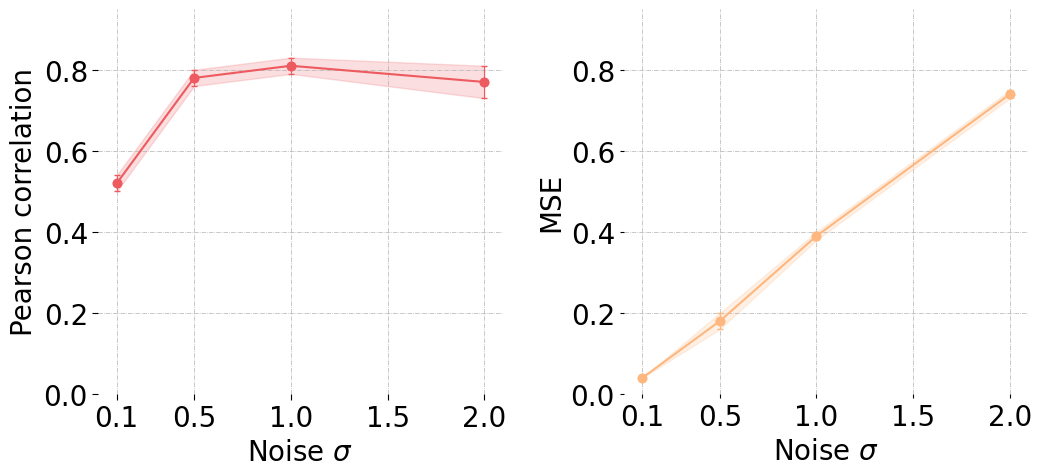

In [15]:
# Errorbar plot 
noise       = [0.1, 0.5, 1.0, 2.0]
pearson     = [0.52, 0.78, 0.81, 0.77]
pearson_err = [0.02, 0.02, 0.02, 0.04]
mse         = [0.04, 0.18, 0.39, 0.74]
mse_err     = [0.00, 0.02, 0.01, 0.01]
color1 = cmap(0.65)
color2 = cmap(0.85)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), gridspec_kw={'wspace': 0.3})

# Pearson correlation subplot
ax1.plot(noise, pearson, marker='o', color=color1)
ax1.fill_between(
    noise,
    [p - e for p, e in zip(pearson, pearson_err)],
    [p + e for p, e in zip(pearson, pearson_err)],
    color=color1, alpha=0.2
)
ax1.errorbar(noise, pearson,yerr=pearson_err,fmt='o', color=color1,ecolor=color1, elinewidth=0.8, capsize=2)
ax1.set_xlabel('Noise $\\sigma$')
ax1.set_ylabel('Pearson correlation')
ax1.set_xticks([0.1, 0.5, 1.0, 1.5, 2.0])
# for spine in ['top', 'right', 'bottom', 'left']:
#     ax1.spines[spine].set_visible(True)
ax1.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, length=4)
ax1.tick_params(axis='y', which='both', left=True, right=False, labelleft=True, length=4)
ax1.set_ylim(0, 0.95)
ax1.grid(True, linewidth=0.5, linestyle='-.')

# MSE subplot
ax2.plot(noise, mse, marker='o', color=color2)
ax2.fill_between(
    noise,
    [m - e for m, e in zip(mse, mse_err)],
    [m + e for m, e in zip(mse, mse_err)],
    color=color2, alpha=0.2
)
ax2.errorbar(noise, mse,yerr=mse_err,fmt='o', color=color2,ecolor=color2, elinewidth=0.8, capsize=2)

ax2.set_xlabel('Noise $\\sigma$')
ax2.set_ylabel('MSE')
# for spine in ['top', 'right', 'bottom', 'left']:
#     ax2.spines[spine].set_visible(True)
ax2.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, length=3)
ax2.tick_params(axis='y', which='both', left=True, right=False, labelleft=True, length=3)
ax2.set_ylim(0, 0.95)
ax2.set_xticks([0.1, 0.5, 1.0, 1.5, 2.0])
ax2.grid(True, linewidth=0.5, linestyle='-.')
plt.tight_layout()
# plt.savefig(f'results/pdfs/app_synth_errorbar.pdf', dpi=300, bbox_inches='tight')
# plt.savefig(f'results/pngs/app_synth_errorbar.png', dpi=300, bbox_inches='tight')
plt.show()